# AdventureWorks Försäljningsanalys
Vi undersöker AdventureWorks data för att besvara affärsfrågor.

- Produktkategorier och försäljning
- Trender
- Segment

Vi använder SQL för att hämta data och Python för visualisering och analys

In [27]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus


user = "SA"
password = quote_plus("TimAjenR!1")
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\timry\AppData\Local\Temp\ipykernel_165580\4029154932.py:24: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [28]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql),conn)

---
## Visualisering 1: Antal produkter per kategori
---
**Affärsfråga: Hur många produkter finns i varje kategori?**

*Använda tabeller*: 
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product

*Plan*:
- Kombinera tabeller för att få fram önskad data
- Räkna DISTINCT produkter per kategori
- Skapa vertikalt stapeldiagram
- Analysera resultat


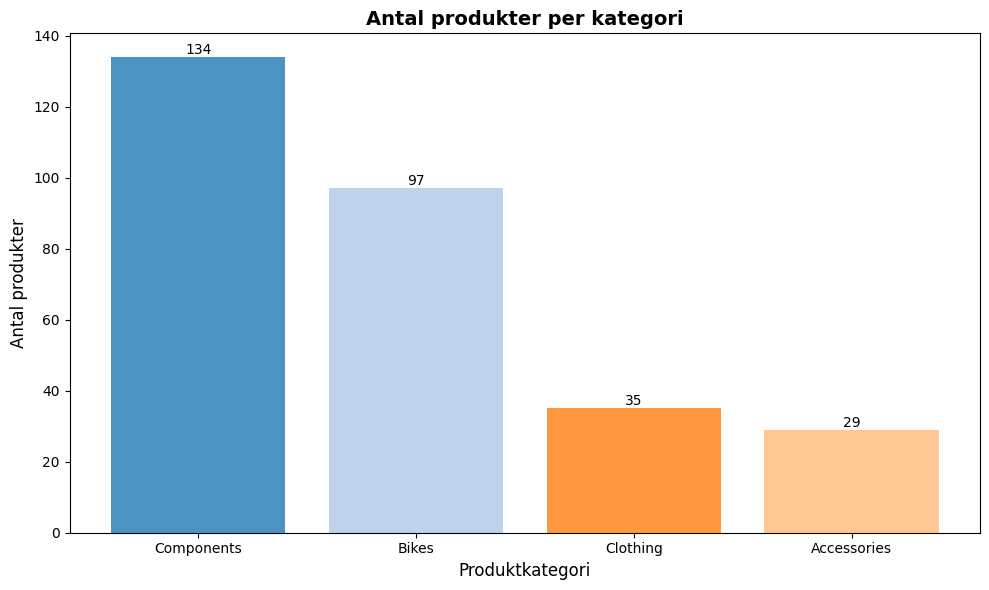

In [29]:
query_vis1 = """

SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC

"""

df_vis1 = query_df(query_vis1)

#Färger
colors = plt.cm.tab20(range(len(df_vis1)))

#Plot
fig, ax = plt.subplots(figsize = (10,6))
bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'],color = colors, alpha = 0.8)

#Siffror
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha = 'center',
        va = 'bottom'
    )

# Titlar
ax.set_xlabel('Produktkategori', fontsize = 12)
ax.set_ylabel('Antal produkter', fontsize = 12)
ax.set_title('Antal produkter per kategori', fontsize = 14, fontweight = 'bold')

#Visa plot
plt.tight_layout()
plt.show()


### ***Insikter - Antal produkter per kategori***
Components har flest produkter på 134 st
Acccessories är minst med 29 produkter.

#### **Slutsats**:  
Företaget har en stor del komponenter och reservdelar. Troligtvis för att stötta deras näst största grupp som är cyklar.
Deras minsta diversifierade produktgrupp är accessories , kan vara ett segment som kan utvecklas.

---
# Visualisering 2: Försäljning per produktkategori
---
**Affärsfråga: Vilka produktkategorier genererar mest intäkter?**   

*Använda tabeller*: 
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

*Plan*:
- Kombinera tabeller för att få fram önskad data
- Med hjälp av aggregering och funktioner få fram önskad data
- Visualisera datan i horissotellt stapeldiagram
- Analysera resultatet.

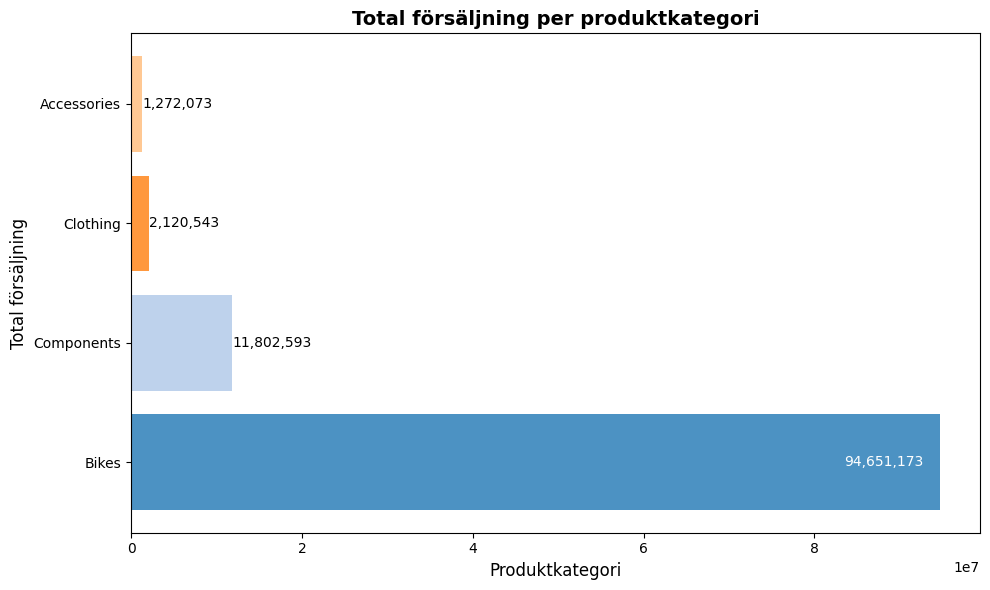

In [30]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC
"""
df_vis2 = query_df(query_vis2)
#Färger
colors = plt.cm.tab20(range(len(df_vis2)))

#Plot
fig, ax = plt.subplots(figsize = (10,6))
bars = ax.barh(df_vis2['CategoryName'], df_vis2['TotalSales'],color = colors, alpha = 0.8)

#Siffror
max_value = df_vis2['TotalSales'].max()

for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    
    if width > 0.15 * max_value:
        x = width * 0.98
        ha = 'right'
        color = 'white'
    else:
        x = width * 1.01
        ha = 'left'
        color = 'black'

    ax.text(
        x,
        y,
        f'{width:,.0f}',
        va='center',
        ha=ha,
        color=color
    )
# Titlar
ax.set_xlabel('Produktkategori', fontsize = 12)
ax.set_ylabel('Total försäljning', fontsize = 12)
ax.set_title('Total försäljning per produktkategori', fontsize = 14, fontweight = 'bold')

#Visa plot
plt.tight_layout()
plt.show()


### ***Insikter - Försäljning per produktkategori***


Majoriteten av försäljningen kommer från "Bikes". 

- Total försäljning på 94.651.172 SEK vilket är ca 86,2% av den totala försäljningen
- Accessories står bara för 1,2% på en total av 1.272.072 SEK

---
# Visualisering 3: Försäljningstrend över tid
---
**Affärsfråga: Hur har försäljningen utvecklats över tid?**

*Använda tabeller*: 
- Sales.SalesOrderHeader   

*Plan*
- Med hjälp av aggregering och funktioner få fram önskad data
- Visalisera med ett linjediagram
- Analysera för trender


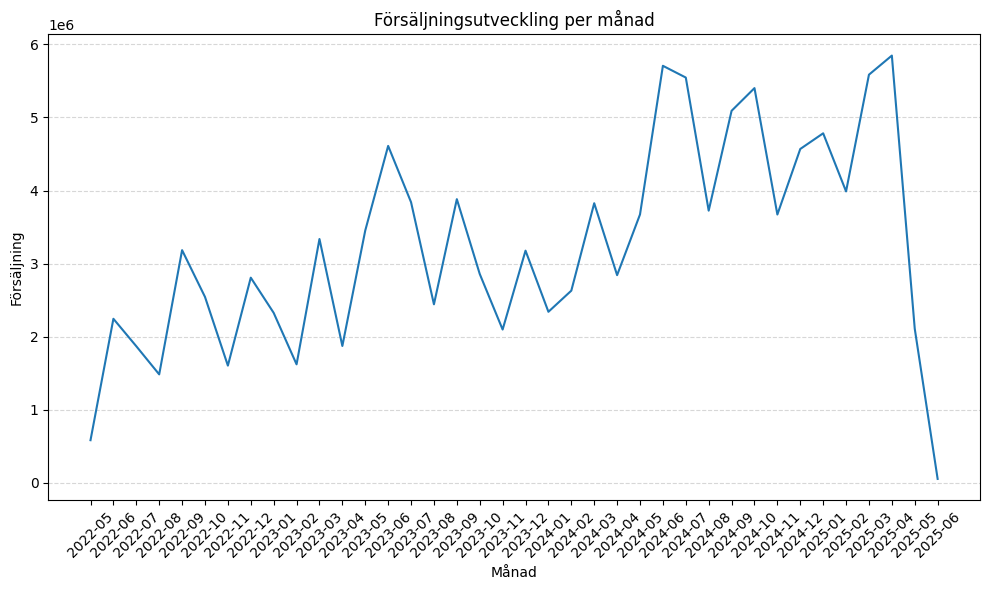

In [31]:
query_vis3 = """
SELECT
    FORMAT(OrderDate, 'yyyy-MM') AS OrderMonth,
    SUM(TotalDue) AS SalesAmount
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY OrderMonth;
"""

df_vis3 = query_df(query_vis3)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(df_vis3['OrderMonth'],df_vis3['SalesAmount'])

ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# Etiketter och titel
ax.set_title("Försäljningsutveckling per månad")
ax.set_xlabel("Månad")
ax.set_ylabel("Försäljning")



# Rotera x-axelns etiketter för bättre läsbarhet
plt.xticks(rotation=45)

# Visa diagrammet
plt.tight_layout()
plt.show()





### **Insikter - Försäljning över tid**
Försäljningen har generellt ökat över perioden 2022–2025, med tydliga säsongsvariationer. 
- Den högsta månaden var april 2025
- Den lägsta var maj 2022. 
- Mönstret tyder på att försäljningen ofta är högre under vår och sommar och lägre under vintermånaderna.

---
# Visualisering 4: Försäljning och antal ordrar per år
---
**Affärsfråga**:   
Hur ser total försäljning och antal ordrar ut per år?   
   
*Använda tabeller*:   
• Sales.SalesOrderHeader   

*Plan*: 
- Med hjälp av aggregering och funktioner få fram önskad data  
- Visualisera resultat med ett grupperat stapeldiagram.
- Analysera resultatet

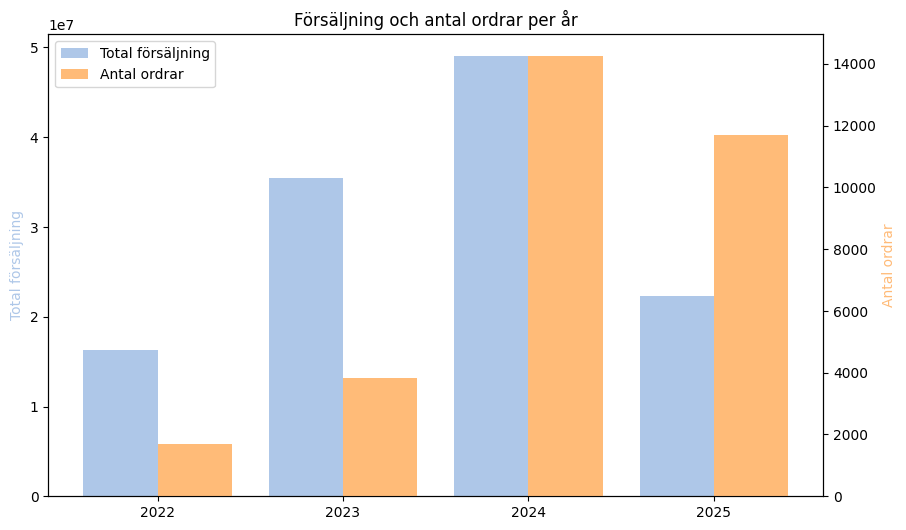

In [32]:
query_vis4 = """
SELECT
    YEAR(OrderDate) AS Year,
    COUNT(SalesOrderID) AS NbrOrders,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY Year;
"""

df_vis4 = query_df(query_vis4)

x = np.arange(len(df_vis4))  # positioner på x-axeln
width = 0.4

fig, ax1 = plt.subplots(figsize=(10,6))

# TotalSales som blå stapel
ax1.bar(x - width/2, df_vis4['TotalSales'], width, color=plt.cm.tab20(1), label='Total försäljning')
ax1.set_ylabel('Total försäljning', color=plt.cm.tab20(1))

# NbrOrders som röd stapel på sekundär y-axel
ax2 = ax1.twinx()
ax2.bar(x + width/2, df_vis4['NbrOrders'], width, color=plt.cm.tab20(3), label='Antal ordrar')
ax2.set_ylabel('Antal ordrar', color=plt.cm.tab20(3))

# X-axel etiketter
ax1.set_xticks(x)
ax1.set_xticklabels(df_vis4['Year'])
plt.title('Försäljning och antal ordrar per år')

# Legend: kombinerar båda
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.show()


### **Insikter - Försäljning och antal orders per år**

Både försäljning och antal ordrar följer samma trend: ökande från 2022 → 2024, sedan en liten nedgång i antal ordrar 2025 men försäljning sjunker ännu mer.

- 2024 var det starkaste året både i försäljning och antal ordrar – toppår för företaget.

- 2025: även om antal ordrar fortfarande är högt (~12 000), minskar total försäljning kraftigt (~22 miljoner).

Detta tyder på lägre genomsnittligt ordervärde – fler men mindre ordrar. Alternativt så är datan för 2025 felaktig

---
### Visualisering 5: Top 10 produkter  
---    
**Affärsfråga**:  
Vilka 10 produkter genererar mest försäljning?   
 
*Använda tabeller*: 
- Production.Product
- Sales.SalesOrderDetail   

*Plan*:   
- Kombinera tabeller för att få fram önskad data
- Aggregera resultat 
- Visualisera resultat i horisontellt stapeldiagram
- Analysera data

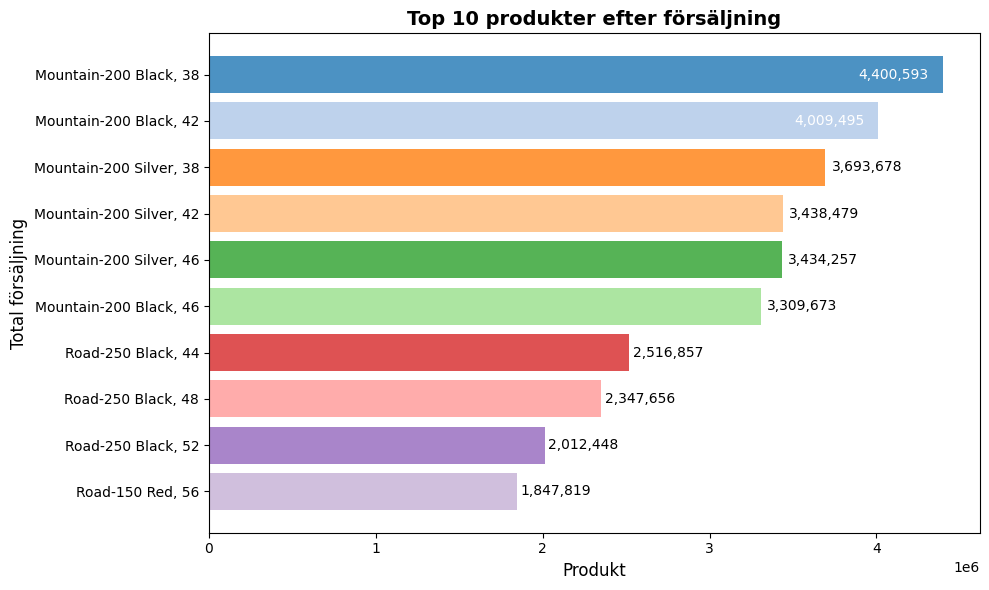

In [33]:
query_vis5 = """
SELECT TOP 10
    p.Name AS ProductName,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail sod
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC;
"""
df_vis5 = query_df(query_vis5)
#Färger
colors = plt.cm.tab20(range(len(df_vis5)))

#Plot
fig, ax = plt.subplots(figsize = (10,6))
bars = ax.barh(df_vis5['ProductName'], df_vis5['TotalSales'],color = colors, alpha = 0.8)

#Siffror
max_value = df_vis5['TotalSales'].max()

for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    
    if width > 0.9 * max_value:
        x = width * 0.98
        ha = 'right'
        color = 'white'
    else:
        x = width * 1.01
        ha = 'left'
        color = 'black'

    ax.text(
        x,
        y,
        f'{width:,.0f}',
        va='center',
        ha=ha,
        color=color
    )
# Titlar
ax.set_xlabel('Produkt', fontsize = 12)
ax.set_ylabel('Total försäljning', fontsize = 12)
ax.set_title('Top 10 produkter efter försäljning', fontsize = 14, fontweight = 'bold')

#Visa plot
ax.invert_yaxis()
plt.tight_layout()
plt.show()


### **Insikter - Top 10 produkter**
Samtliga 10 artiklar är inom kategorin "Bikes" och bästa produkten är "Mountain-200 BLACK,38" med en total försäljning på 4,400,592 SEK

---
### Visualisering 6: Försäljning och antal kunder per region
---   
**Affärsfråga**:   
Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?   

*Använda tabeller*: 
- Sales.SalesTerritory, 
- Sales.SalesOrderHeader 
- Sales.Customer

*Plan*: 
- Kombinera tabeller för att få fram önskad data
- Aggregera resultat 
- Använda funktioner för att få fram önskat resultat
- Visualisera resultatet i grupperat stapeldiagram
- Analysera resultatet


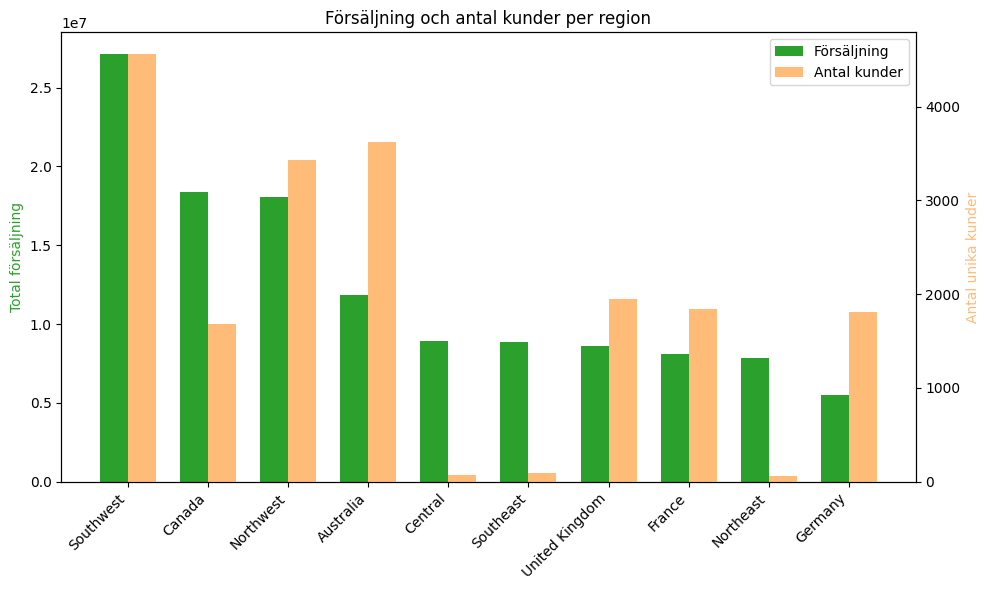

In [34]:
query_vis6 = """
SELECT
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT c.CustomerID) AS UniqueCustomers
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh ON st.TerritoryID = soh.TerritoryID
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC;
"""
df_vis6 = query_df(query_vis6)

x = np.arange(len(df_vis6))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Stapel 1: Försäljning
ax1.bar(x - width/2, df_vis6["TotalSales"], width, label="Försäljning", color = plt.cm.tab20(4))
ax1.set_ylabel("Total försäljning",color = plt.cm.tab20(4))

# Stapel 2: Antal kunder (sekundär axel)
ax2 = ax1.twinx()
ax2.bar(x + width/2, df_vis6["UniqueCustomers"], width, label="Antal kunder", color = plt.cm.tab20(3))
ax2.set_ylabel("Antal unika kunder",color = plt.cm.tab20(3))

# X-axel
ax1.set_xticks(x)
ax1.set_xticklabels(df_vis6["Region"], rotation=45, ha="right")

# Titel
ax1.set_title("Försäljning och antal kunder per region")

# Gemensam legend

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')


plt.tight_layout()
plt.show()

### **Insikter - Försäljning och antal kunder per region**

Diagrammet visar försäljning (grön stapel) och antal unika kunder (orange stapel) för olika regioner.

##### **Starkaste och svagaste regioner**

- **Starkast (högst försäljning):**  
  *Central* – toppar både försäljning och kundantal.

- **Svagast (lägst försäljning):**  
  *Tyskland* – lägst i försäljning.

**Många kunder men låg omsättning**

Ni har några regioner med många kunder men lägre försäljning jämför med Southwest.

- Australia , Northwest, United Kingdom, France, Germany

Det tyder på lägre snittorder och fler mindre köp.

**Få kunder men hög omsättning**

Ni har även några regioner med få kunder men ändå någorlunda hög omsättning.

- Central, Southeast, Northeast

Det tyder på att området har ett fåtal kunder som står för majoriteten av omsättningen i områdena.


---
### Visualisering 7: Genomsnittligt ordervärde per region och kundtyp
---   

**Affärsfråga**:   
Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

*Använda tabeller*: 
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer
- Sales.Store

*Plan*:
- Kombinera tabeller för önskat resultat
- Aggregera datan
- Med hjälp av funktioner få fram önskat resultat
- Visualisera datan med grupperat stapeldiagram
- Analysera resultatet  


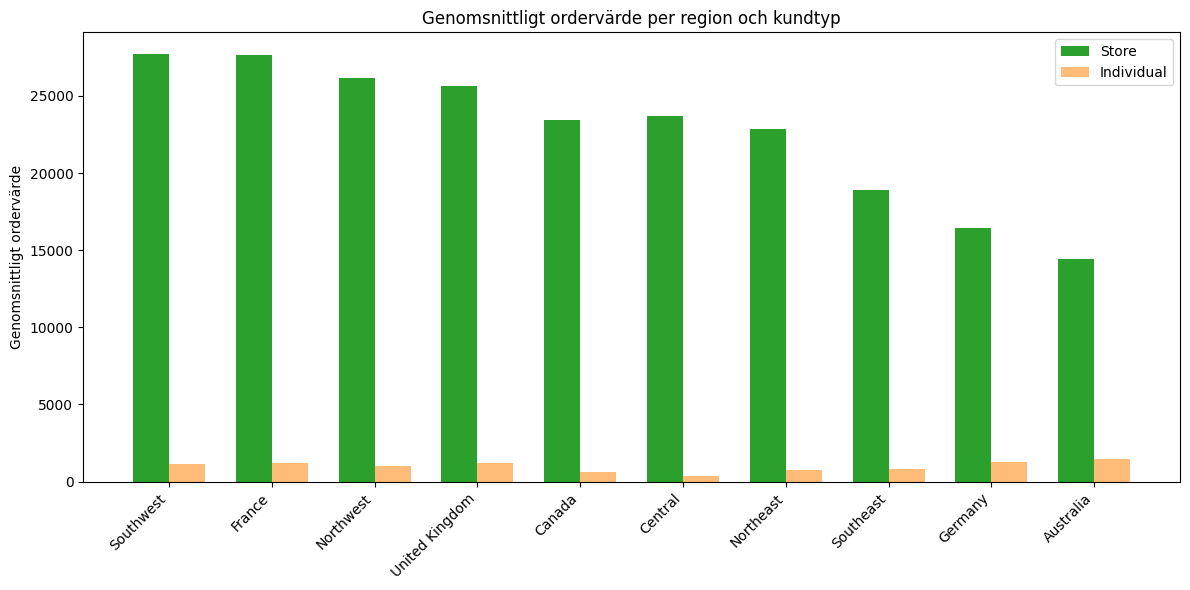

In [35]:
query_vis7 = """
SELECT
    t.Name AS Region,
    CASE
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END AS CustomerType,
    AVG(soh.TotalDue) AS AvgOrderValue
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory t ON soh.TerritoryID = t.TerritoryID
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
GROUP BY
    t.Name,
    CASE
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END
ORDER BY AVG(soh.TotalDue) DESC;
"""
df_vis7 = query_df(query_vis7)



region_totals = df_vis7.groupby("Region")["AvgOrderValue"].sum().sort_values(ascending=False)
regions_sorted = region_totals.index.tolist()  # Regioner sorterade från högst till lägst totalt

x = np.arange(len(regions_sorted))

width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Stapel 1: Store
ax.bar(
    x - width/2,
    df_vis7.loc[df_vis7["CustomerType"] == "Store"].set_index("Region").reindex(regions_sorted)["AvgOrderValue"],
    width,
    label="Store",
    color=plt.cm.tab20(4)
)

# Stapel 2 Individual
ax.bar(
    x + width/2,
    df_vis7.loc[df_vis7["CustomerType"] == "Individual"].set_index("Region").reindex(regions_sorted)["AvgOrderValue"],
    width,
    label="Individual",
    color=plt.cm.tab20(3)
)

# X-axel
ax.set_xticks(x)
ax.set_xticklabels(regions_sorted, rotation=45, ha="right")

# Y-axel och titel
ax.set_ylabel("Genomsnittligt ordervärde")
ax.set_title("Genomsnittligt ordervärde per region och kundtyp")

# Legend
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

### **Insikter - Genomsnittligt ordervärde per region och kundtyp**

Diagrammet visar genomsnittligt ordervärde för två kundtyper – **Store** (grön stapel) och **Individual** (orange stapel) – över olika regioner.


**Store vs Individual**

- Store-kunder har konsekvent högre ordervärde än Individual-kunder i alla regioner.
- Skillnaden är tydlig och ofta flera gånger högre.
- Australia sticker ut, där har Individual-kunder högre ordervärde än i andra regioner – kan tyda på annan köpbeteende eller produktmix.

**Möjliga orsaker**

- **Store-kunder** är sannolikt företag eller återförsäljare → större inköp per order.
- **Individual-kunder** handlar mindre, kanske mer frekvent men med lägre belopp.

**Slutsats**

- Store-kunder är nyckeln till högre intäkter per order.
- Regional strategi bör anpassas efter kundtypens beteende.
- Australia kan vara intressant för att förstå varför individer handlar mer där än i andra regioner.

---
## VG Analys: ALTERNATIV B: Produktportfölj-analys
---

**Analysfrågor:**
- Vilka produkter är "winners" (hög försäljning, hög marginal)?
- Vilka är "losers" (låg försäljning eller negativ marginal)?
- Vilka produkter bör vi sluta sälja? Vilka bör vi satsa mer på?
- Finns produkter med hög kvantitet men låg intäkt?  


Du behöver:  
-	3-4 nya SQL-queries för att analysera produkters lönsamhet och prestanda
-	Minst 1 pivot tables för att jämföra produkter
-	3 nya visualiseringar (t.ex. scatter plot marginal×försäljning, grupperade staplar för kategorier, matris för winners/losers)

---
### Visualisering 1/2: Vilka är våra bästa/Sämsta produkter?
---
**Affärsfråga 1: Vilka produkter är "winners" (hög försäljning, hög marginal)?**   
**Affärsfråga 2: Vilka är "losers" (låg försäljning eller negativ marginal)?**

*Använda tabeller:*
- Sales.SalesOrderDetal
- Production.Product
- Production.ProductSubcategory
- Production.ProductCategory
- Production.ProductCostistory

*Plan:*
- Kombinera tabllerer för önskad data
- Aggregera datan för önskat resultat
- Dela upp produkterna i olika segment (Winner, Low Perfomance, Neutral, Loser)
- Visualisera resultatet
- Identifiera våra bästa och sämsta produkter
- Analysera resultatet

*Förklaring produktsegementering:*

- **Winner** - Produkter som ligger över medel i både omsättning och vinst (Grön)
- **Low Perfomance** - Produkter som ligger under medel i vinst (Gul)
- **Loser** - Produkter som inte genererar vinst (Röd)
- **Neutral** - Övriga (Grå)


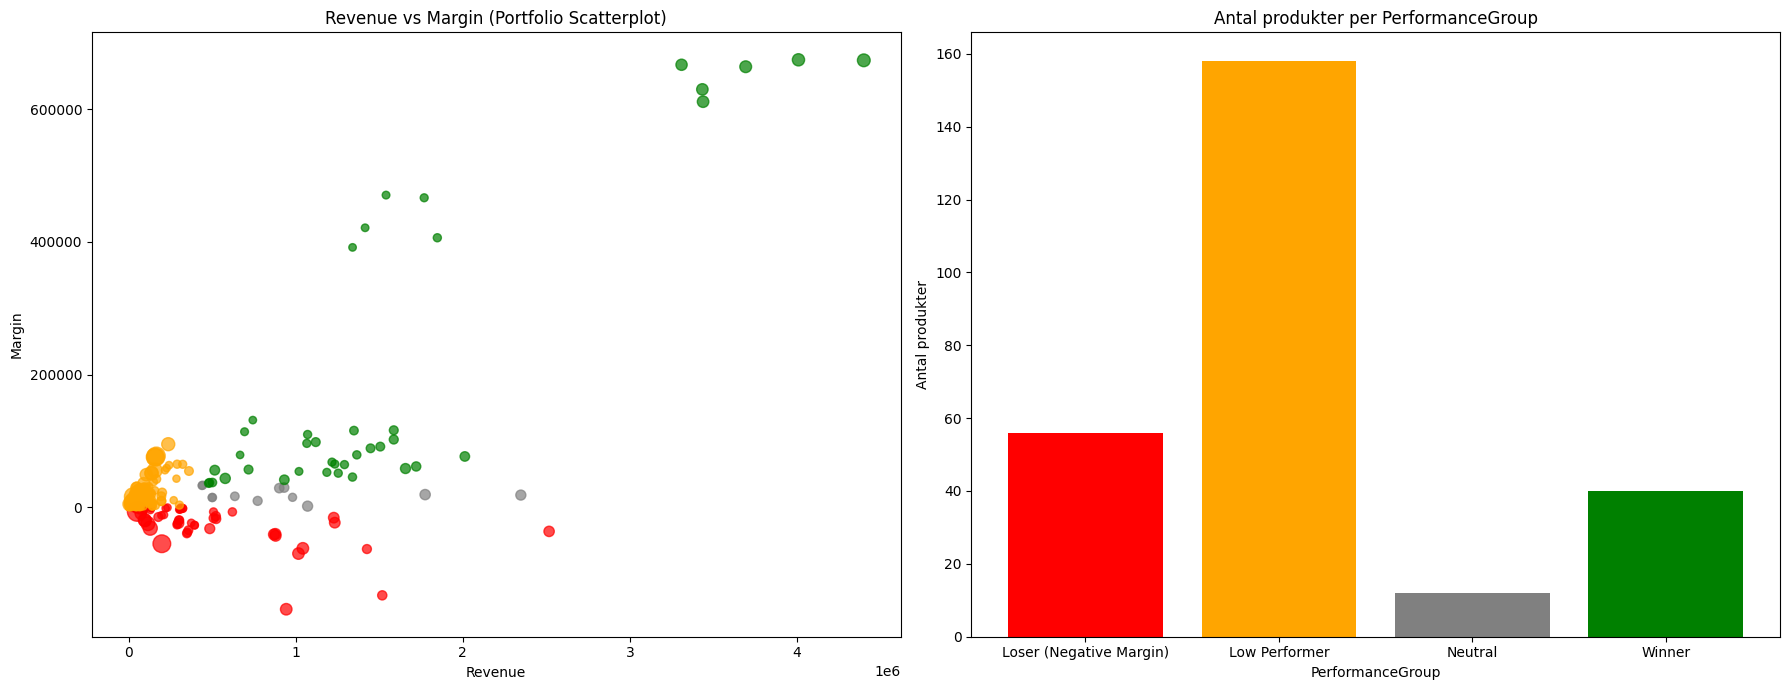

=== Top 10 bästa produkter (Margin) ===


,Name,ProductCategory,Qty,Revenue,Margin,PerformanceGroup
227,"Mountain-200 Black, 42",Bikes,2664,4.009495e+06,674216.578641,Winner
226,"Mountain-200 Black, 38",Bikes,2977,4.400593e+06,673444.470300,Winner
231,"Mountain-200 Black, 46",Bikes,2111,3.309673e+06,666740.692608,Winner
228,"Mountain-200 Silver, 38",Bikes,2394,3.693678e+06,663784.942272,Winner
230,"Mountain-200 Silver, 46",Bikes,2216,3.434257e+06,629644.129928,Winner
229,"Mountain-200 Silver, 42",Bikes,2234,3.438479e+06,611084.897423,Winner
239,"Road-150 Red, 48",Bikes,493,1.540803e+06,470355.021400,Winner
234,"Road-150 Red, 62",Bikes,600,1.769097e+06,466320.168000,Winner
242,"Road-150 Red, 52",Bikes,458,1.415564e+06,421110.868400,Winner
233,"Road-150 Red, 56",Bikes,664,1.847819e+06,406079.279200,Winner



=== Top 10 sämsta produkter (Margin) ===


,Name,ProductCategory,Qty,Revenue,Margin,PerformanceGroup
7,"Road-650 Red, 44",Bikes,2254,9.433406e+05,-153696.116612,Loser (Negative Margin)
1,"Touring-1000 Yellow, 60",Bikes,1114,1.518133e+06,-132745.719453,Loser (Negative Margin)
6,"Road-650 Red, 60",Bikes,2232,1.016529e+06,-69800.112786,Loser (Negative Margin)
2,"Touring-1000 Yellow, 46",Bikes,1005,1.426373e+06,-62974.720176,Loser (Negative Margin)
5,"Road-650 Black, 52",Bikes,2270,1.042910e+06,-61914.203970,Loser (Negative Margin)
37,"Long-Sleeve Logo Jersey, L",Clothing,6592,1.987550e+05,-54986.266240,Loser (Negative Margin)
8,"Road-650 Red, 62",Bikes,1896,8.798279e+05,-42967.775357,Loser (Negative Margin)
10,"Road-650 Black, 58",Bikes,1871,8.696328e+05,-40995.266149,Loser (Negative Margin)
9,"Road-650 Red, 48",Bikes,1888,8.786667e+05,-40235.397140,Loser (Negative Margin)
22,"Touring-3000 Blue, 50",Bikes,841,3.485815e+05,-39493.573285,Loser (Negative Margin)



=== Top 10 sämsta produkter (Qty) ===


,Name,ProductCategory,Qty,Revenue,Margin,PerformanceGroup
211,"LL Touring Frame - Blue, 58",Components,4,800.208,0.8004,Low Performer
208,"ML Mountain Frame-W - Silver, 38",Components,7,1529.178,133.5481,Low Performer
210,"LL Mountain Frame - Black, 40",Components,8,1198.992,104.7120,Low Performer
213,LL Road Seat/Saddle,Components,10,162.720,42.3070,Low Performer
203,"LL Touring Frame - Blue, 62",Components,15,3000.780,3.0015,Low Performer
204,"LL Mountain Frame - Black, 52",Components,15,2248.110,196.3350,Low Performer
178,"HL Mountain Frame - Black, 44",Components,17,13765.920,1881.3424,Low Performer
201,"LL Touring Frame - Blue, 44",Components,25,5001.300,5.0025,Low Performer
195,"LL Touring Frame - Yellow, 58",Components,36,7201.872,7.2036,Low Performer
197,"LL Mountain Frame - Silver, 48",Components,44,6970.920,608.7928,Low Performer


In [36]:
query_vis1VG = """
WITH Profit AS (
    SELECT 
        p.ProductID,
        p.Name,
        pc.Name AS ProductCategory,
        psc.Name AS ProductSubcategory,
        SUM(sod.LineTotal) AS Revenue,
        SUM(sod.OrderQty) AS Qty,
        SUM(sod.LineTotal) - SUM(sod.OrderQty * c.StandardCost) AS Margin
    FROM Sales.SalesOrderDetail sod
    JOIN Production.Product p ON sod.ProductID = p.ProductID
    LEFT JOIN Production.ProductSubcategory psc 
        ON p.ProductSubcategoryID = psc.ProductSubcategoryID
    LEFT JOIN Production.ProductCategory pc 
        ON psc.ProductCategoryID = pc.ProductCategoryID
    JOIN (
        SELECT ProductID, StandardCost,
               ROW_NUMBER() OVER (PARTITION BY ProductID ORDER BY StartDate DESC) AS rn
        FROM Production.ProductCostHistory
    ) c ON c.ProductID = p.ProductID AND c.rn = 1
    GROUP BY p.ProductID, p.Name, pc.Name, psc.Name
)
SELECT *,
    CASE 
        WHEN Revenue > (SELECT AVG(Revenue) FROM Profit)
         AND Margin > (SELECT AVG(Margin) FROM Profit)
        THEN 'Winner'
        WHEN Margin < 0 THEN 'Loser (Negative Margin)'
        WHEN Revenue < (SELECT AVG(Revenue) FROM Profit) THEN 'Low Performer'
        ELSE 'Neutral'
    END AS PerformanceGroup
FROM Profit
ORDER BY PerformanceGroup, Revenue DESC;

"""

df_vis1VG = query_df(query_vis1VG)

#  Normalisera punktstorlek 
qty_min = df_vis1VG['Qty'].min()
qty_max = df_vis1VG['Qty'].max()

df_vis1VG['PointSize'] = 20 + (df_vis1VG['Qty'] - qty_min) / (qty_max - qty_min) * 180

#  Räkna antal produkter per PerformanceGroup 
category_counts = (
    df_vis1VG.groupby('PerformanceGroup')
             .size()
             .reset_index(name='AntalProdukter')
)

#  Färgkarta för PerformanceGroup 
color_map = {
    'Winner': 'green',
    'Loser (Negative Margin)': 'red',
    'Low Performer': 'orange',
    'Neutral': 'gray'
}

# Färger för scatterploten baserat på PerformanceGroup
colors = df_vis1VG['PerformanceGroup'].map(color_map)

#  Subplots 
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1 Scatterplot (vänster)
axes[0].scatter(
    df_vis1VG['Revenue'],
    df_vis1VG['Margin'],
    c=colors,
    s=df_vis1VG['PointSize'],
    alpha=0.7
)

axes[0].set_title("Revenue vs Margin (Portfolio Scatterplot)")
axes[0].set_xlabel("Revenue")
axes[0].set_ylabel("Margin")


# Bar chart: antal produkter per PerformanceGroup (höger)

axes[1].bar(
    category_counts['PerformanceGroup'],
    category_counts['AntalProdukter'],
    color=[color_map[c] for c in category_counts['PerformanceGroup']]
)

axes[1].set_title("Antal produkter per PerformanceGroup")
axes[1].set_xlabel("PerformanceGroup")
axes[1].set_ylabel("Antal produkter")

plt.tight_layout()
plt.show()

# Top 10 bästa produkter (högst margin)
top10_best_margin = (
    df_vis1VG.sort_values('Margin', ascending=False)
             .head(10)[['Name', 'ProductCategory', 'Qty', 'Revenue', 'Margin','PerformanceGroup']]
)

# Top 10 sämsta produkter (lägst margin)
top10_worst_margin = (
    df_vis1VG.sort_values('Margin', ascending=True)
             .head(10)[['Name', 'ProductCategory', 'Qty', 'Revenue', 'Margin','PerformanceGroup']]
)

top10_worst_qty = (
    df_vis1VG.sort_values('Qty', ascending=True)
             .head(10)[['Name', 'ProductCategory', 'Qty', 'Revenue', 'Margin','PerformanceGroup']]
)
print("=== Top 10 bästa produkter (Margin) ===")
display(top10_best_margin)

print("\n=== Top 10 sämsta produkter (Margin) ===")
display(top10_worst_margin)

print("\n=== Top 10 sämsta produkter (Qty) ===")
display(top10_worst_qty)

### **Insikter - Vilka produkter är "winners" (hög försäljning, hög marginal)?**
- Bästa produkten är cykeln "Mountain-200 Black" och "Mountain-200 Silver" i storlekarna 38,42,46.

**Slutsats**:   
De produkter som ger högst intäkter är cyklarna. 

### **Insikter - Vilka är "losers" (låg försäljning eller negativ marginal)?**

- Sämsta produkterna är "Road-650 Red, 44" och "Touring-1000 Yellow, 60" som har högst förlust.
- De sämst sålda produkterna är t.ex. "LL Touring Frame - Blue, 58" och "ML Mountain Frame-W - Silver, 38"
- Nästan 60 st artiklar i produktsortimentet genererar inga vinster.

**Slutsats:**   
Lite av "Bikes"-sortimentet är svårsålda och därav troligtvis fått säljas till förlust. Majoriteten av produkterna som säljs i låga antal är Cykel-ramar och de genererar inte heller så mycket vinst.   
Borde se över samtliga produkter som inte genererar någon vinst utan iställer förlust.


---
### Visualisering 3: Vilka är våra bästsäljande samt sämstsäljande produker?
---
**Affärsfråga: Vilka produkter bör vi sluta sälja? Vilka bör vi satsa mer på?**

*Använda tabeller:*
- Sales.SalesOrderDetail
- Production.Product
- Production.ProductSubcategory
- Production.ProductCategory
- Production.ProductCostHistory


*Plan:*
- Vill få fram vilken produktkategori som generar mest vinst samt vilken kategori som har bäst vinstmarginal
- Kombinera tabeller för att få fram önskad data 
- Aggregera och använda funktioner för att få fram önskat resultat
- Visualisera resultat mha graf samt Pivot-tabell
- Analysera datan



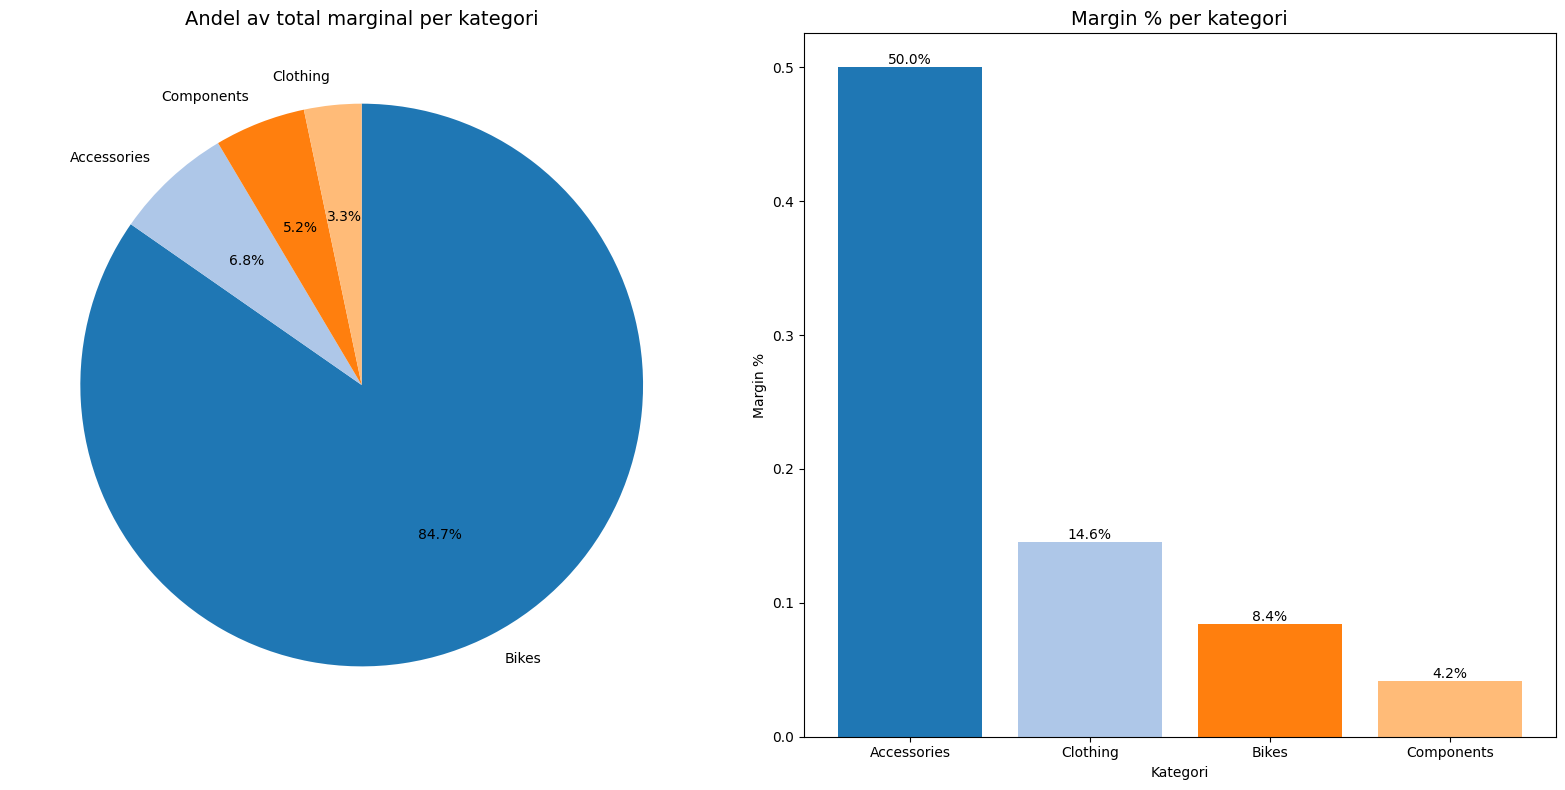

,Margin,Qty,Revenue
ProductCategory,,,
Accessories,6.363943e+05,61932,1.272073e+06
Bikes,7.936394e+06,90268,9.465117e+07
Clothing,3.088822e+05,73670,2.120543e+06
Components,4.902332e+05,49044,1.180259e+07


In [53]:
query_vis3VG = """
WITH Profit AS (
    SELECT 
        pc.Name AS ProductCategory,
        SUM(sod.LineTotal) AS Revenue,
        SUM(sod.OrderQty) AS Qty,
        SUM(sod.LineTotal) - SUM(sod.OrderQty * c.StandardCost) AS Margin
    FROM Sales.SalesOrderDetail sod
    JOIN Production.Product p ON sod.ProductID = p.ProductID
    LEFT JOIN Production.ProductSubcategory psc  
        ON p.ProductSubcategoryID = psc.ProductSubcategoryID
    LEFT JOIN Production.ProductCategory pc 
        ON psc.ProductCategoryID = pc.ProductCategoryID
    JOIN (
        SELECT ProductID, StandardCost,
               ROW_NUMBER() OVER (PARTITION BY ProductID ORDER BY StartDate DESC) AS rn
        FROM Production.ProductCostHistory
    ) c ON c.ProductID = p.ProductID AND c.rn = 1
    GROUP BY pc.Name
),

Totals AS (
    SELECT SUM(Margin) AS GrandTotalMargin
    FROM Profit
)

SELECT 
    ProductCategory,
    SUM(Revenue) AS TotalRevenue,
    SUM(Margin) AS TotalMargin,
    SUM(Qty) AS TotalQty,
    SUM(Margin) * 1.0 / NULLIF(SUM(Revenue), 0) AS MarginPct,
    SUM(Margin) * 1.0 / t.GrandTotalMargin AS MarginShare,
    RANK() OVER (ORDER BY SUM(Margin) DESC) AS CategoryRank
FROM Profit
CROSS JOIN Totals t
GROUP BY ProductCategory, t.GrandTotalMargin
ORDER BY CategoryRank
"""

df_vis3VG = query_df(query_vis3VG)

colors = plt.cm.tab20(range(len(df_vis3VG)))
df_sorted = df_vis3VG.sort_values("MarginPct", ascending=False)
bar_colors = plt.cm.tab20(range(len(df_sorted)))

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].pie(
    df_vis3VG['MarginShare'],
    labels=df_vis3VG['ProductCategory'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    colors=colors
)
axes[0].set_title("Andel av total marginal per kategori", fontsize=14)

axes[1].bar(
    df_sorted['ProductCategory'],
    df_sorted['MarginPct'],
    color=bar_colors
)
axes[1].set_title("Margin % per kategori", fontsize=14)
axes[1].set_xlabel("Kategori")
axes[1].set_ylabel("Margin %")

for i, v in enumerate(df_sorted['MarginPct']):
    axes[1].text(i, v, f"{v:.1%}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

query_Pivot = """

SELECT 
    pc.Name AS ProductCategory,
    p.Name AS Name,
    SUM(sod.OrderQty) AS Qty,
    SUM(sod.LineTotal) AS Revenue,
    SUM(sod.LineTotal) - SUM(sod.OrderQty * c.StandardCost) AS Margin
FROM Sales.SalesOrderDetail sod
INNER JOIN Production.Product p 
    ON sod.ProductID = p.ProductID
LEFT JOIN Production.ProductSubcategory psc
    ON p.ProductSubcategoryID = psc.ProductSubcategoryID
LEFT JOIN Production.ProductCategory pc
    ON psc.ProductCategoryID = pc.ProductCategoryID
INNER JOIN (
    SELECT 
        ProductID,
        StandardCost,
        ROW_NUMBER() OVER (PARTITION BY ProductID ORDER BY StartDate DESC) AS rn
    FROM Production.ProductCostHistory
) c ON c.ProductID = p.ProductID AND c.rn = 1
GROUP BY 
    pc.Name,
    p.Name
ORDER BY 
    pc.Name,
    p.Name;

"""

df_Pivot = query_df(query_Pivot)

df_Pivot.pivot_table(
    index="ProductCategory",
    values=["Qty", "Revenue", "Margin"],
    aggfunc="sum"
)

### **Insikter - Vilka produkter bör vi sluta sälja? Vilka bör vi satsa mer på?**
- Det produktsortimentet som genererar mest vinst är  "Bikes" som står för 84.7 % av den totala vinsten men har bara en marginal på 8.4%
- Produktsortimentet som har högst vinstmarginal är "Accesories" på en vinstmarginal på 50%
- "Components" står för 5.2% av vinsten men har en väldigt låg marginal på 4,2%
- "Clothing" står bara för 3.3% av den total vinsten men har näst högst vinstmarginal på 14.6%

**Slutsats**   
Genom att analysera produktkategorierna så kan man göra följande slutsats. 

Pivot‑tabellen visar tydligt hur kategorierna presterar när man summerar Qty, Revenue och Margin.

Majoriteten av företagets vinst står "Bikes" för och är ett sortiment som borde fokusera på, om man kan öka vinstmarginalen med t.ex. hitta de cyklar som säljs bäst med högst marginal så kan det ge en positiv utgång på företagets resultat.   

"Accesories" har en hög vinstmarginal men står för en liten del av vinsten. Kan vara ett sortiment som borde utvecklas för att ta vara på den höga vinstmarginalen. En annan produkt som borde utvecklas och eventuellt prioriteras är "Clothing" som har en hög vinstmarginal men står för en liten den av vinsten. Så kan försäljningen av "Clothes" öka så skulle det generera en bra vinst.

"Components" har en väldigt liten vinstmarginal samt står för en liten del av den totala vinsten. Beroende på kostnaden att ha den i sortimentent så kan det vara en produktkategori som kan vara värt att släppa.

---
### Visualisering 4: Vilka produkter har vi hög produktomsättning på men dålig intäkt?
---
**Affärsfråga: Finns produkter med hög kvantitet men låg intäkt?**

*Använda tabeller:*
- Sales.SalesOrderDetail
- Production.Product
- Production.ProductSubcategory
- Production.ProductCategory
- Production.ProductCostHistory

*Plan:*
- Kombinera tabeller för att få fram önskad data
- Mha funktioner och aggregering få fram önskat resultat
- Visualisera resultatet
- Analysera resultatet


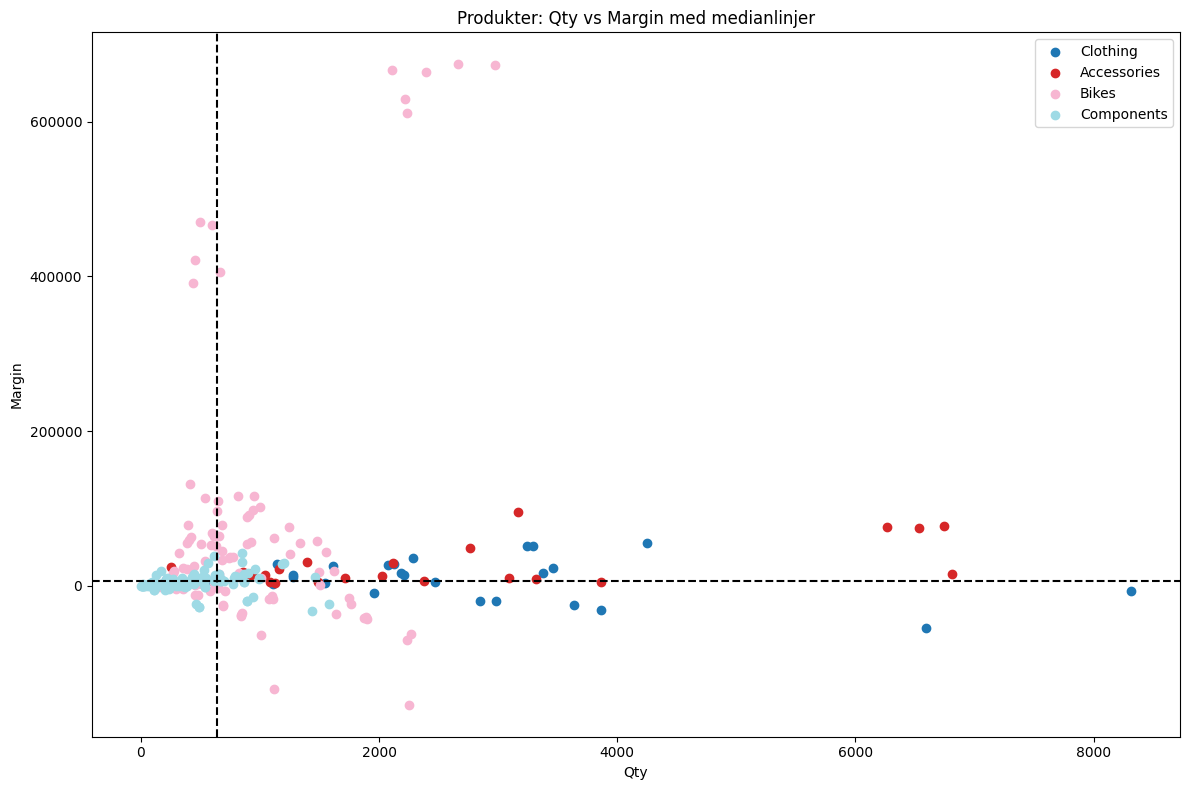

In [47]:
query_vis4VG = """

WITH ProductTotals AS (
    SELECT 
        p.ProductID,
        p.Name,
        pc.Name AS ProductCategory,
        SUM(sod.OrderQty) AS Qty,
        SUM(sod.LineTotal) AS Revenue,
        SUM(sod.LineTotal) - SUM(sod.OrderQty * c.StandardCost) AS Margin
    FROM Sales.SalesOrderDetail sod
    INNER JOIN Production.Product p 
        ON sod.ProductID = p.ProductID
    LEFT JOIN Production.ProductSubcategory psc
        ON p.ProductSubcategoryID = psc.ProductSubcategoryID
    LEFT JOIN Production.ProductCategory pc
        ON psc.ProductCategoryID = pc.ProductCategoryID
    INNER JOIN (
        SELECT 
            ProductID,
            StandardCost,
            ROW_NUMBER() OVER (PARTITION BY ProductID ORDER BY StartDate DESC) AS rn
        FROM Production.ProductCostHistory
    ) c ON c.ProductID = p.ProductID AND c.rn = 1
    GROUP BY p.ProductID, p.Name, pc.Name
)
SELECT 
    pt.ProductID,
    pt.Name,
    pt.ProductCategory,
    pt.Qty,
    pt.Margin
FROM ProductTotals pt
ORDER BY pt.Qty DESC;

"""

df_vis4VG = query_df(query_vis4VG)


median_qty = df_vis4VG['Qty'].median()
median_margin = df_vis4VG['Margin'].median()

categories = df_vis4VG['ProductCategory'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(categories)))
color_map = dict(zip(categories, colors))

fig, ax = plt.subplots(figsize=(12, 8))

for cat in categories:
    subset = df_vis4VG[df_vis4VG['ProductCategory'] == cat]
    ax.scatter(subset['Qty'], subset['Margin'], color=color_map[cat], label=cat)

ax.axvline(median_qty, color='black', linestyle='--')
ax.axhline(median_margin, color='black', linestyle='--')

ax.set_xlabel("Qty")
ax.set_ylabel("Margin")
ax.set_title("Produkter: Qty vs Margin med medianlinjer")
ax.legend()

plt.tight_layout()
plt.show()

### **Insikter - Finns produkter med hög kvantitet men låg intäkt?**
- Det finns ett fåtal "Clothing"-artiklar som ligger över medel kvantitet men ligger i negativ vinst.
- Ett antal "Bikes"-artiklar som säljer i högt antal men genererar negativ vinst.

**Slutsats**   
Genom att dela upp samtliga artiklar utifrån median kvantitet samt intäkt så kan man få en bra översikt kring produktsortimenten. Borde fokusera på att minimera antal produkter som har högt antal men negativ intäkt.

# (VG) Reflektion

## Varför valde jag denna djupanalys?
Jag valde att göra en produktportfölj‑analys eftersom den ger en tydlig och praktisk bild av hur företagets produkter faktiskt presterar. Målet var att förstå vilka produkter som driver försäljning och marginal, vilka som är svaga, och vilka som bör prioriteras eller eventuellt fasas ut. Analysen gör det möjligt att se både helheten och detaljerna, och ger ett bra beslutsunderlag för sortiment, prissättning och fokusområden.

---

## Varför valde jag att göra aggregering i SQL istället för Pandas?
Jag valde att göra aggregeringen i SQL eftersom databasen är optimerad för just den typen av beräkningar. SQL hanterar joins, summeringar och filtrering snabbare och mer effektivt än Pandas, och det gör koden renare och mer överskådlig. Genom att göra logiken i SQL får jag dessutom en tydlig och reproducerbar datagrund innan jag går vidare till visualiseringar i Python.   
Samt så ville jag öva på SQL.

---

## Varför valde jag dessa typer av diagram?
Jag valde diagram som direkt svarar på affärsfrågorna:

- **Scatter plot (Revenue × Margin)** för att visuellt identifiera winners och losers.
- **Scatter plot (Qty × Margin)** för att hitta produkter som säljer mycket men tjänar dåligt.
- **Bar chart (PerformanceGroup)** för att se hur många produkter som hamnar i respektive segment.
- **Pie chart + stapeldiagram** för att visa marginalandel och marginalprocent per kategori.

Dessa diagram kompletterar varandra och gör det enkelt att se mönster och avvikelser i datan.

---

## Hur hjälpte pivot‑tabellen mig att se mönster i datan?
Pivot‑tabellen gav en snabb överblick över hur produktkategorierna presterar totalt sett. Genom att summera Qty, Revenue och Margin per kategori blev det tydligt vilka kategorier som står för mest försäljning, vilka som har hög marginal och vilka som är svagare. Pivoten fungerar som en sammanfattning som knyter ihop visualiseringarna och gör det lättare att se helheten.

---

## Utmaningar och hur jag löste dem

**1. Margin krävde senaste kostnaden**  
StandardCost varierar över tid.  
*Lösning:* använde ROW_NUMBER() för att hämta senaste kostnaden per produkt.

**2. Segmentering av winners/losers**  
Behövde tydliga gränser.  
*Lösning:* använde medelvärden för Revenue och Margin som trösklar.

**3. Punktstorlek i scatter plots**  
Qty‑värdena varierade kraftigt.  
*Lösning:* normaliserade punktstorleken för bättre läsbarhet.

---

## Konkreta rekommendationer baserat på analysen
1. **Fokusera på Bikes**  
   Står för majoriteten av vinsten men har låg marginal. Här finns potential att förbättra lönsamheten.

2. **Utveckla Accessories och Clothing**  
   Hög marginalprocent men låg försäljning. Bra kandidater för marknadsföring eller sortimentsutökning.

3. **Se över Components**  
   Låg marginal och låg försäljning. Kan vara ett sortiment att minska eller optimera.

4. **Justera priset på produkter med hög volym men låg marginal**  
   Dessa produkter driver mycket försäljning men bidrar lite till resultatet.

5. **Fasa ut produkter med negativ marginal**  
   Nästan 60 produkter säljs med förlust och bör åtgärdas.

6. **Fortsätt analysera produktmixen löpande**  
   För att säkerställa att sortimentet är lönsamt över tid.

---



# Sammanfattning

## Huvudsakliga fynd
- Bikes står för ~85 % av vinsten men har låg marginal.
- Accessories och Clothing har hög marginalprocent men låg försäljning.
- Components är svag både i marginal och försäljning.
- Flera produkter säljs med negativ marginal.
- Det finns produkter som säljer mycket men tjänar dåligt.
- Winners är främst cyklar i Mountain‑serien.
- Losers är framför allt cykelramar och vissa Road‑modeller.
- “Store"‑kunder står för en stor del av försäljningen och har betydligt högre ordervärden än individuella kunder. 

---

## Rekommendationer
- Prioritera Bikes och förbättra marginalen.  
- Satsa mer på Accessories och Clothing.  
- Optimera eller fasa ut Components.  
- Ta bort produkter med negativ marginal.  
- Justera priset på produkter med hög volym men låg intäkt.  
- Fortsätt analysera produktmixen regelbundet.
- Då "Store"-kunder står för en stor del av försäljningen så borde det tas med i sortimentsstrategin.